In [215]:
from lib.models.deepsdf import DeepSDF
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.rendering.utils import normalize


class Object3D:
    def signed_distance(self):
        raise NotImplementedError()

    def normal(self):
        raise NotImplementedError()


class SDF(Object3D):
    def __init__(self, ckpt_path=str, obj_idx: int = 0):
        self.model = DeepSDF.load_from_checkpoint(ckpt_path).eval()
        self.lat_vec = self.model.lat_vecs(torch.tensor(obj_idx))

    def signed_distance(self, point):
        x = (
            torch.tensor(point, dtype=torch.float32)[None, None],
            self.lat_vec[None, None],
        )
        return self.model.predict(x).squeeze().item()

    def signed_distance_batch(self, points):
        x = (
            torch.tensor(points, dtype=torch.float32)[None, None],
            self.lat_vec[None, None],
        )
        return self.model.predict(x).squeeze().item()


class Circle(Object3D):
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def signed_distance(self, point):
        center = self.center
        radius = self.radius
        surface_point = normalize(point - center) * radius
        dist = np.linalg.norm(surface_point - point)
        if np.linalg.norm(surface_point - center) > np.linalg.norm(point - center):
            dist *= -1
        return dist

    def normal(self, point):
        return normalize(self.center - point)


sdf_obj = SDF(ckpt_path="/Users/robinborth/Code/sketch2shape/logs/last.ckpt", obj_idx=34)
circle_obj = Circle(center=np.array([0, 0, 0]), radius=1)

/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.1.0
/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


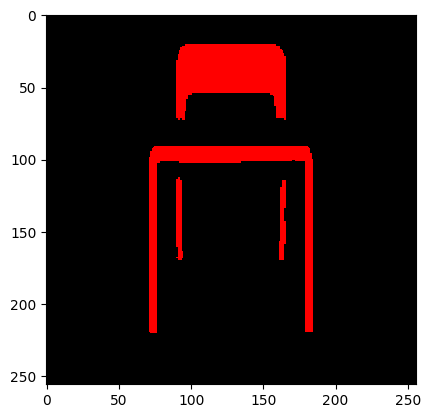

In [62]:
resolution = 256
dist = 1.2
camera = np.array([0, 0.2, -(1 + dist)])
xs = np.linspace(-0.5, 0.5, resolution)
ys = np.linspace(0.5, -0.5, resolution)
zs = np.full((resolution, resolution), -dist)
grid = np.meshgrid(xs, ys)
canvas = np.stack([grid[0], grid[1], zs], axis=-1)

image = np.full((resolution, resolution, 3), 0)
ray = normalize(canvas - camera)
depth = np.zeros_like(ray)

for _ in range(20):
    point = camera + depth * ray
    points = point.reshape(1, -1, 3)
    lat_vec = sdf_obj.lat_vec[None, None]
    lat_vec = np.repeat(lat_vec.detach().numpy(), points.shape[1], axis=1)
    x = (
        torch.tensor(points, dtype=torch.float32),
        torch.tensor(lat_vec, dtype=torch.float32),
    )
    out = sdf_obj.model.predict(x)
    sd = out.view(resolution, resolution, -1).detach().numpy()
    idx = np.where(sd < 5e-03)
    image[idx] = 1
    depth += sd * 0.6
plt.imshow(image * 255, cmap="viridis", interpolation="nearest")

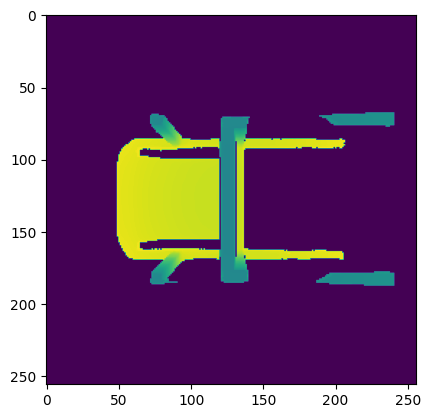

In [221]:
resolution = 256
dist = 1.2
camera = torch.tensor([0, 0.0, -(1 + dist)])

xs = torch.linspace(-0.5, 0.5, resolution)
ys = torch.linspace(0.5, -0.5, resolution)
zs = torch.full((resolution, resolution), -dist)

grid = torch.meshgrid(xs, ys)
canvas = torch.stack([grid[0], grid[1], zs], dim=-1)
image = torch.stack([grid[0], grid[1], zs], dim=-1)
# image = torch.full((resolution, resolution, 3), 0)
# image = camera.clone().expand((256, 256, -1))

ray = (canvas - camera) / torch.linalg.norm((canvas - camera), dim=-1)[..., None]
depth = torch.zeros_like(ray)

lat_vec = sdf_obj.lat_vec[None, None].expand((resolution, resolution, -1))
for _ in range(50):
    point = camera + depth * ray
    sd = sdf_obj.model.predict((point, lat_vec))
    idx = torch.where(sd.squeeze() < 5e-03) 
    image[idx] = point[idx]
    depth += sd * 1.0
img = torch.linalg.norm((image - canvas), dim=-1)
plt.imshow(img)

/var/folders/s9/pkchj30d7jx_xt2n0gk9gl0w0000gn/T/ipykernel_40298/209855873.py:1: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:711.)
  image[idx] = point[idx]


In [201]:
image

tensor([[[ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         ...,
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706]],

        [[ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         ...,
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706]],

        [[ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         ...,
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706]],

        ...,

        [[ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         ...,
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706],
         [ 0.3832, -0.7596, -0.4706]],

        [[

In [84]:
lat_vec = sdf_obj.lat_vec[None, None].expand((256, 256, -1))
# lat_vec.expand((-1, points.shape[1], -1)).shape
# lat_vec = torch.expand(lat_vec, points.shape[1], dim=1)

In [88]:
sdf_obj.model.predict((point, lat_vec)).

torch.Size([256, 256, 1])

In [12]:
image


class Camera:
    def __init__(
        self,
        dist: int = 1,
        elev: float = 0.0,
        azim: float = 0.0,
        image_size: int = 64,
    ):
        _point = elev_azim_to_unit_shere(elev=elev, azim=azim)
        self.center_image_plane = _point * dist

        self._width_vec = elev_azim_to_unit_shere(elev=elev, azim=(azim + 90))
        self.xs = np.linspace(-1, 1, image_size)

        self._height_vec = elev_azim_to_unit_shere(elev=(elev + 90), azim=azim)
        self.ys = np.linspace(1, -1, image_size)

        # self.location = _point * (dist + 2)

        # self.image_size = image_size

        # dist_to_line_of_sight = 2

        # self.z = camera[2] + d

    def canvas_pixel(self, xi, yi):
        _x = self.xs[xi] * self._width_vec
        _y = self.ys[yi] * self._height_vec
        return self.center_image_plane + _x + _y

    @property
    def empty_canvas(self):
        return np.full((self.resolution, self.resolution, 3), 0)

    @property
    def canvas(self):
        zs = np.full((self.resolution, self.resolution), self.z)
        grid = np.meshgrid(self.xs, self.ys)
        return np.stack([grid[0], grid[1], zs], axis=-1)


camera = Camera(elev=0, azim=0, dist=1, image_size=256)
camera.center_image_plane

NameError: name 'elev_azim_to_unit_shere' is not defined

In [198]:
elev_azim_to_unit_shere(elev=90, azim=0)

array([0., 0., 1.])

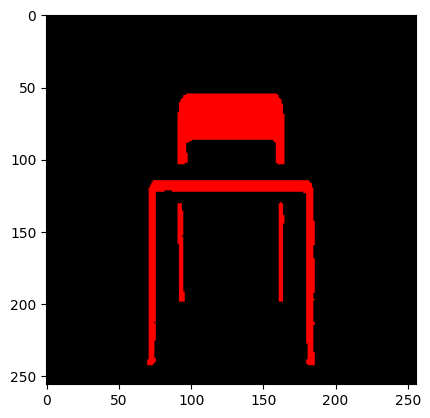

In [157]:
plt.imshow(image * 255)

In [141]:
sd = np.repeat(sd, 3, axis=-1).ravel()

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [142]:
image.ravel()
point.ravel()[sd]

(256, 256, 3)

In [133]:
image.ravel()

(196608,)

In [112]:
image[idx, :] = point[idx, :]

In [113]:
image

array([[[ 6,  6,  9],
        [ 6,  6,  9],
        [ 6,  6,  9],
        ...,
        [-6,  6,  9],
        [-6,  6,  9],
        [-6,  6,  9]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]])

In [30]:
image[idx[0], idx[1], :]

(5061, 3)

In [282]:
image[:] = point[idx]

ValueError: could not broadcast input array from shape (5214,) into shape (256,256,3)

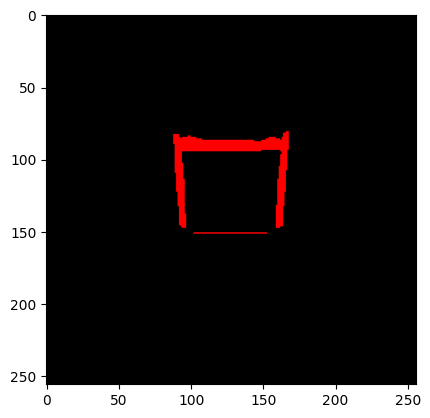

In [211]:
plt.imshow((image - 1) * 255)